---
## Step 1: Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## Step 2: Load and Explore Dataset

In [2]:
# Load dataset from Kaggle input
import os

# List files in the dataset directory
dataset_path = '/kaggle/input/bangladesh-road-accident-data-from-prothom-alo'
print("Files in dataset:")
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files in dataset:
/kaggle/input/bangladesh-road-accident-data-from-prothom-alo/road_accidents_bangladesh_cleaned.csv


In [4]:
# Load the CSV file (adjust filename if needed)
df = pd.read_csv(f'{dataset_path}/road_accidents_bangladesh_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Dataset shape: (2985, 13)

Columns: ['id', 'title', 'date', 'article_url', 'place_of_accident', 'district', 'number_of_deaths', 'number_of_injured', 'vehicle_type', 'cause_of_accident', 'country', 'report_type', 'type_of_accident']

First few rows:


,id,title,date,article_url,place_of_accident,district,number_of_deaths,number_of_injured,vehicle_type,cause_of_accident,country,report_type,type_of_accident
0,6,"Road accident in Cox’s Bazar leaves 3 dead, 7 ...",2025-06-16 11:43:58,https://en.prothomalo.com/bangladesh/accident/...,chattogram-cox’s bazar highway in ramu upazila,cox’s bazar,3,7,passenger bus and a covered van,head-on collision,Bangladesh,event,road accident
1,8,"Two killed, four injured in Khulna road accident",2025-06-09 12:29:25,https://en.prothomalo.com/bangladesh/accident/...,darogar bhita area near rupsha bridge,khulna,2,4,truck and easy-bike,head-on collision,Bangladesh,event,road accident
2,12,Marma girl's accident injury being propagated ...,2025-01-18 17:15:50,https://en.prothomalo.com/bangladesh/ij8ukl3niq,chattogram,chattogram,0,1,bike,bike accident,Bangladesh,event,road accident
3,15,Four killed in two separate accidents on expre...,2025-01-03 11:19:06,https://en.prothomalo.com/bangladesh/accident/...,nimtala area in sirajdikhan upazila,munshiganj,2,5,bus and covered van,bus rammed into a parked covered van,Bangladesh,event,road accident
4,16,"Cause of accident, whereabouts of driver still...",2024-12-28 14:09:42,https://en.prothomalo.com/bangladesh/local-new...,dhaleshwari toll plaza on dhaka-mawa expressway,NaN,6,0,"bus, cars",NaN,Bangladesh,event,road accident


In [5]:
# Dataset overview
print("Dataset Info:")
df.info()

print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())

print("\n" + "="*50)
print("Basic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985 entries, 0 to 2984
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2985 non-null   int64 
 1   title              2985 non-null   object
 2   date               2985 non-null   object
 3   article_url        2637 non-null   object
 4   place_of_accident  2937 non-null   object
 5   district           2878 non-null   object
 6   number_of_deaths   2985 non-null   int64 
 7   number_of_injured  2985 non-null   int64 
 8   vehicle_type       2365 non-null   object
 9   cause_of_accident  2525 non-null   object
 10  country            2985 non-null   object
 11  report_type        2980 non-null   object
 12  type_of_accident   2985 non-null   object
dtypes: int64(3), object(10)
memory usage: 303.3+ KB

Missing Values:
id                     0
title                  0
date                   0
article_url          348
plac

,id,number_of_deaths,number_of_injured
count,2985.000000,2985.000000,2985.000000
mean,2966.335008,10.167504,11.345729
std,1827.436556,91.047649,135.455546
min,6.000000,0.000000,-1.000000
25%,1344.000000,1.000000,0.000000
50%,2926.000000,2.000000,0.000000
75%,4327.000000,3.000000,3.000000
max,6516.000000,1810.000000,2515.000000


---
## Step 2: Data Cleaning (Essential Only)

**Cleaning steps:**
- Remove rows where title is missing
- Remove rows where both deaths AND injuries are missing
- Convert date → year, month, weekday
- Lowercase all text fields
- Remove extra spaces and symbols

In [6]:
# Create a copy for cleaning
df_clean = df.copy()

print(f"Initial dataset size: {len(df_clean)}")

# Remove rows where title is missing
df_clean = df_clean[df_clean['title'].notna()]
print(f"After removing missing titles: {len(df_clean)}")

# Remove rows where BOTH deaths AND injuries are missing
df_clean = df_clean[~(df_clean['number_of_deaths'].isna() & df_clean['number_of_injured'].isna())]
print(f"After removing rows with no casualty info: {len(df_clean)}")

# Fill NaN values in deaths and injuries with 0
df_clean['number_of_deaths'] = df_clean['number_of_deaths'].fillna(0)
df_clean['number_of_injured'] = df_clean['number_of_injured'].fillna(0)

print(f"\n✅ Final cleaned dataset size: {len(df_clean)}")

Initial dataset size: 2985
After removing missing titles: 2985
After removing rows with no casualty info: 2985

✅ Final cleaned dataset size: 2985


In [7]:
# Convert date column to datetime and extract features
date_col = 'date'  # Adjust if your date column has a different name

if date_col in df_clean.columns:
    df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce')
    df_clean['year'] = df_clean[date_col].dt.year
    df_clean['month'] = df_clean[date_col].dt.month
    df_clean['weekday'] = df_clean[date_col].dt.dayofweek  # Monday=0, Sunday=6
    print("✅ Date features extracted: year, month, weekday")
else:
    print("⚠️ Date column not found. Skipping date feature extraction.")

✅ Date features extracted: year, month, weekday


In [8]:
# Function to clean text
def clean_text(text):
    """Clean text: lowercase, remove extra spaces and special characters"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # Remove special characters
    return text.strip()

# Apply text cleaning to relevant columns
text_columns = ['title', 'cause_of_accident', 'vehicle_type', 'district']

for col in text_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_text)
        print(f"✅ Cleaned: {col}")

print("\n✅ Text cleaning completed!")

✅ Cleaned: title
✅ Cleaned: cause_of_accident
✅ Cleaned: vehicle_type
✅ Cleaned: district

✅ Text cleaning completed!


In [9]:
# Display cleaned data sample
print("Cleaned data sample:")
df_clean[['title', 'number_of_deaths', 'number_of_injured']].head(10)

Cleaned data sample:


,title,number_of_deaths,number_of_injured
0,road accident in cox s bazar leaves 3 dead 7 ...,3,7
1,two killed four injured in khulna road accident,2,4
2,marma girl s accident injury being propagated ...,0,1
3,four killed in two separate accidents on expre...,2,5
4,cause of accident whereabouts of driver still...,6,0
5,one killed as 10 vehicles collide in 4 acciden...,1,15
6,disinformation spreads in india about shyamoli...,0,0
7,ju student dies in battery run rickshaw accide...,1,0
8,compliance to traffic rules can prevent road a...,0,0
9,four of same family killed in sirajganj road a...,4,1


---
## Step 3: Define Severity Labels

**Severity Rules:**
- **Low:** 0 deaths AND ≤2 injured
- **Medium:** 1 death OR 3-5 injured
- **High:** ≥2 deaths OR >5 injured

Severity Distribution:
severity
High      1931
Medium     641
Low        413
Name: count, dtype: int64

Percentages:
severity
High      64.690117
Medium    21.474037
Low       13.835846
Name: proportion, dtype: float64


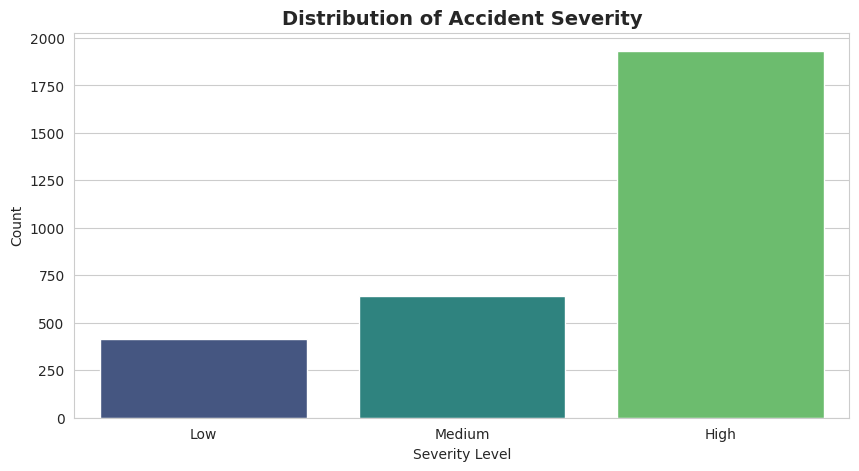


✅ Severity labels created successfully!


In [10]:
def assign_severity(row):
    """Assign severity label based on deaths and injuries"""
    deaths = row['number_of_deaths']
    injured = row['number_of_injured']
    
    # High severity
    if deaths >= 2 or injured > 5:
        return 'High'
    # Medium severity
    elif deaths == 1 or (3 <= injured <= 5):
        return 'Medium'
    # Low severity
    else:
        return 'Low'

# Apply severity labeling
df_clean['severity'] = df_clean.apply(assign_severity, axis=1)

# Display severity distribution
print("Severity Distribution:")
print(df_clean['severity'].value_counts())
print("\nPercentages:")
print(df_clean['severity'].value_counts(normalize=True) * 100)

# Visualize distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='severity', order=['Low', 'Medium', 'High'], palette='viridis')
plt.title('Distribution of Accident Severity', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

print("\n✅ Severity labels created successfully!")

---
## Step 4: Prepare Text for ML

**Actions:**
- Combine title + cause_of_accident into one text column
- Remove stopwords
- Keep unigrams + bigrams

In [11]:
# Combine text fields
df_clean['combined_text'] = df_clean['title'].fillna('') + ' ' + df_clean['cause_of_accident'].fillna('')
df_clean['combined_text'] = df_clean['combined_text'].str.strip()

print("Sample combined text:")
for i, text in enumerate(df_clean['combined_text'].head(3)):
    print(f"\n{i+1}. {text[:200]}...")

print(f"\n✅ Combined text created for {len(df_clean)} records")

Sample combined text:

1. road accident in cox s bazar leaves 3 dead  7 injured head on collision...

2. two killed  four injured in khulna road accident head on collision...

3. marma girl s accident injury being propagated as communal murder bike accident...

✅ Combined text created for 2985 records


In [12]:
# Define stopwords (basic English stopwords)
stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'
])

print(f"Using {len(stopwords)} stopwords for text processing")

Using 93 stopwords for text processing


---
## Step 5: Create Feature Sets

**Two feature groups:**
1. **Text Features:** TF-IDF representation (top 2000 terms)
2. **Structured Features:** Vehicle type, district, month, weekday

In [13]:
# Create TF-IDF features from combined text
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2),  # unigrams + bigrams
    stop_words=list(stopwords),
    min_df=2,  # minimum document frequency
    max_df=0.8  # maximum document frequency
)

# Fit and transform
tfidf_features = tfidf_vectorizer.fit_transform(df_clean['combined_text'])

print(f"✅ TF-IDF Features created: {tfidf_features.shape}")
print(f"   - Samples: {tfidf_features.shape[0]}")
print(f"   - Features: {tfidf_features.shape[1]}")

# Show top terms
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample terms: {list(feature_names[:20])}")

✅ TF-IDF Features created: (2985, 2000)
   - Samples: 2985
   - Features: 2000

Sample terms: ['000', '10', '10 die', '10 hurt', '10 injured', '10 killed', '100', '11', '11 injured', '11 lives', '12', '12 people', '13', '13 killed', '14', '15', '15 injured', '16', '17', '17 killed']


In [14]:
# Create structured features
structured_features = pd.DataFrame()

# Label encode district
if 'district' in df_clean.columns:
    le_district = LabelEncoder()
    structured_features['district_encoded'] = le_district.fit_transform(df_clean['district'].fillna('unknown'))

# One-hot encode vehicle type (keep top categories)
if 'vehicle_type' in df_clean.columns:
    # Get top vehicle types
    top_vehicles = df_clean['vehicle_type'].value_counts().head(10).index
    df_clean['vehicle_type_grouped'] = df_clean['vehicle_type'].apply(
        lambda x: x if x in top_vehicles else 'other'
    )
    vehicle_dummies = pd.get_dummies(df_clean['vehicle_type_grouped'], prefix='vehicle')
    structured_features = pd.concat([structured_features, vehicle_dummies], axis=1)

# Add temporal features
if 'month' in df_clean.columns:
    structured_features['month'] = df_clean['month'].fillna(0)
if 'weekday' in df_clean.columns:
    structured_features['weekday'] = df_clean['weekday'].fillna(0)

print(f"✅ Structured Features created: {structured_features.shape}")
print(f"\nStructured feature columns:")
print(structured_features.columns.tolist())

✅ Structured Features created: (2985, 14)

Structured feature columns:
['district_encoded', 'vehicle_', 'vehicle_bus', 'vehicle_bus  auto rickshaw', 'vehicle_bus and auto rickshaw', 'vehicle_bus and truck', 'vehicle_car', 'vehicle_motorcycle', 'vehicle_motorcycle  truck', 'vehicle_other', 'vehicle_truck', 'vehicle_truck  auto rickshaw', 'month', 'weekday']


---
## Step 6: Accident Pattern Discovery (Clustering)

**Goal:** Apply K-Means clustering on TF-IDF text to discover accident patterns

k=3: Silhouette Score = 0.0135
k=4: Silhouette Score = 0.0182
k=5: Silhouette Score = 0.0178


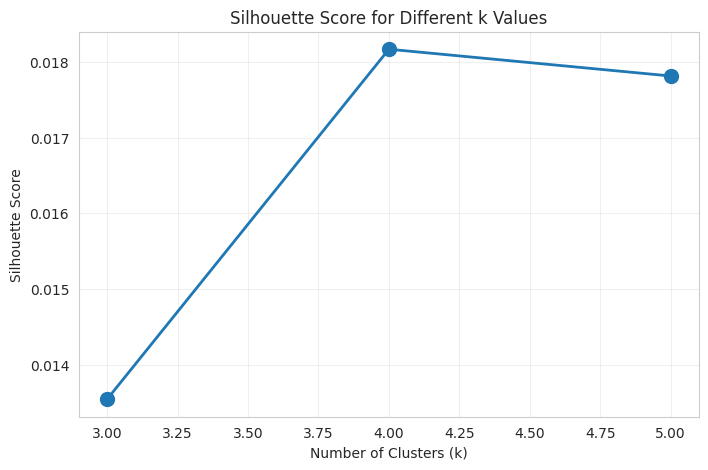


✅ Best k value: 4


In [15]:
# Try different values of k
k_values = [3, 4, 5]
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_features)
    score = silhouette_score(tfidf_features, cluster_labels, sample_size=1000)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k Values')
plt.grid(True, alpha=0.3)
plt.show()

# Choose best k
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\n✅ Best k value: {best_k}")

Cluster distribution:
cluster
0     391
1     256
2    1411
3     927
Name: count, dtype: int64


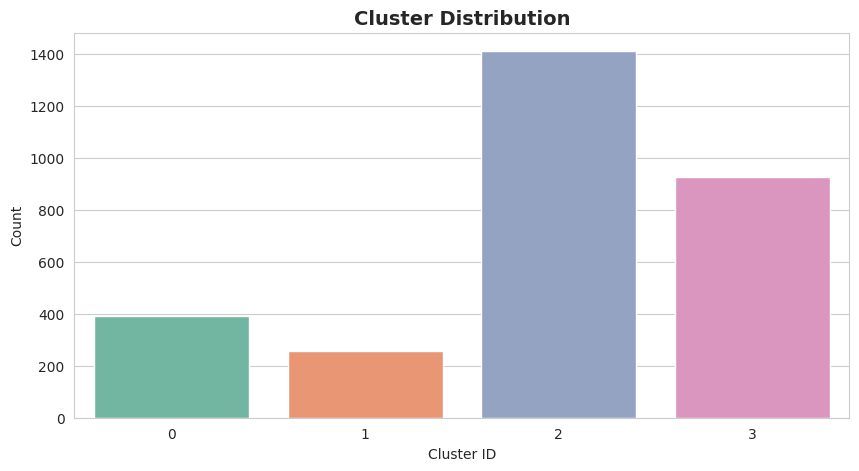

In [16]:
# Apply K-Means with best k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_clean['cluster'] = kmeans_final.fit_predict(tfidf_features)

print(f"Cluster distribution:")
print(df_clean['cluster'].value_counts().sort_index())

# Visualize cluster distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='cluster', palette='Set2')
plt.title('Cluster Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.show()

---
## Step 7: Interpret Clusters (Critical)

**Analysis:** Extract top keywords, vehicle types, and casualty statistics for each cluster

In [17]:
# Function to get top terms per cluster
def get_top_keywords(cluster_id, n_terms=10):
    """Get top TF-IDF terms for a cluster"""
    cluster_center = kmeans_final.cluster_centers_[cluster_id]
    top_indices = cluster_center.argsort()[-n_terms:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    return top_terms

# Analyze each cluster
cluster_analysis = []

for cluster_id in range(best_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    # Top keywords
    keywords = get_top_keywords(cluster_id, n_terms=8)
    
    # Most common vehicle type
    if 'vehicle_type' in df_clean.columns:
        dominant_vehicle = cluster_data['vehicle_type'].value_counts().index[0] if len(cluster_data) > 0 else 'N/A'
    else:
        dominant_vehicle = 'N/A'
    
    # Average casualties
    avg_deaths = cluster_data['number_of_deaths'].mean()
    avg_injured = cluster_data['number_of_injured'].mean()
    
    # Severity distribution
    severity_dist = cluster_data['severity'].value_counts()
    
    cluster_analysis.append({
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Keywords': ', '.join(keywords[:5]),
        'Dominant_Vehicle': dominant_vehicle,
        'Avg_Deaths': f"{avg_deaths:.2f}",
        'Avg_Injured': f"{avg_injured:.2f}",
        'High_Severity_%': f"{(severity_dist.get('High', 0) / len(cluster_data) * 100):.1f}%"
    })
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ({len(cluster_data)} accidents)")
    print(f"{'='*80}")
    print(f"Top Keywords: {', '.join(keywords)}")
    print(f"Dominant Vehicle: {dominant_vehicle}")
    print(f"Avg Deaths: {avg_deaths:.2f}, Avg Injured: {avg_injured:.2f}")
    print(f"\nSeverity Distribution:")
    print(severity_dist)
    print(f"\nSample Titles:")
    for i, title in enumerate(cluster_data['title'].head(3), 1):
        print(f"{i}. {title[:100]}...")

# Create summary table
cluster_summary = pd.DataFrame(cluster_analysis)
print("\n" + "="*80)
print("CLUSTER SUMMARY TABLE")
print("="*80)
print(cluster_summary.to_string(index=False))


CLUSTER 0 (391 accidents)
Top Keywords: accident, road accident, road, killed, accident kills, collision, killed road, accident head
Dominant Vehicle: 
Avg Deaths: 2.46, Avg Injured: 3.33

Severity Distribution:
severity
High      277
Medium    102
Low        12
Name: count, dtype: int64

Sample Titles:
1. road accident in cox s bazar leaves 3 dead  7 injured...
2. two killed  four injured in khulna road accident...
3. marma girl s accident injury being propagated as communal murder...

CLUSTER 1 (256 accidents)
Top Keywords: head, head collision, collision, crash head, road crash, crash, killed, road
Dominant Vehicle: two buses
Avg Deaths: 3.41, Avg Injured: 7.08

Severity Distribution:
severity
High      236
Medium     18
Low         2
Name: count, dtype: int64

Sample Titles:
1. road accident on dhaka sylhet highway kills 3...
2. 2 killed in mymensingh road crash...
3. 2 killed in mymensingh road crash...

CLUSTER 2 (1411 accidents)
Top Keywords: bus, killed, crashes, fire, truck, 

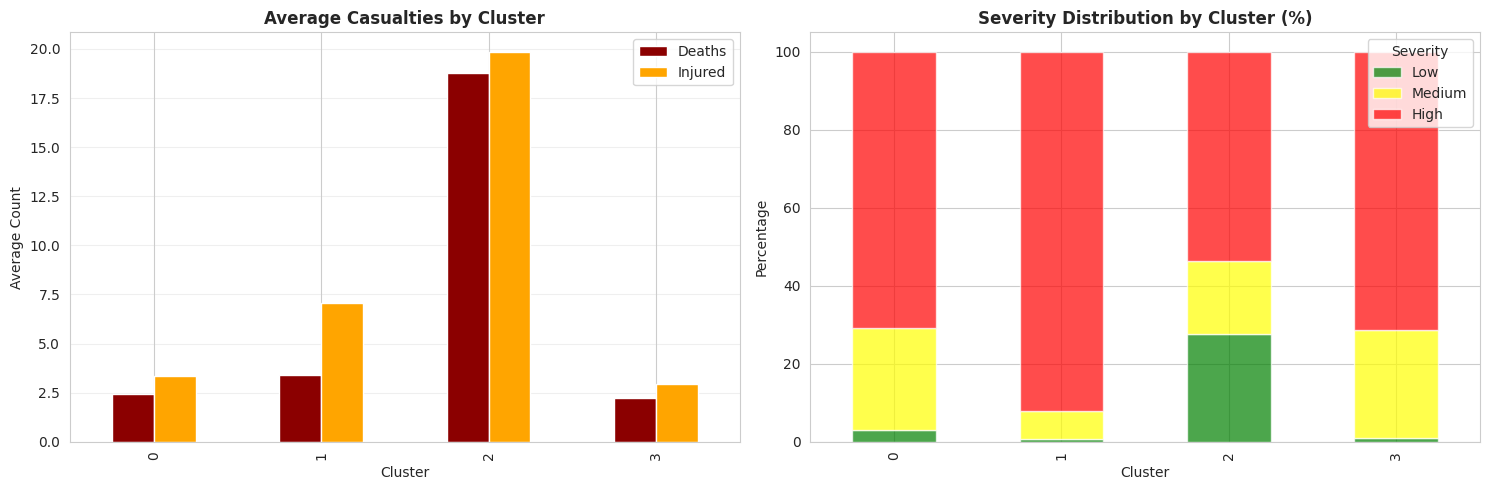


✅ Cluster analysis completed!


In [18]:
# Visualize cluster characteristics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Average casualties by cluster
cluster_stats = df_clean.groupby('cluster')[['number_of_deaths', 'number_of_injured']].mean()
cluster_stats.plot(kind='bar', ax=axes[0], color=['darkred', 'orange'])
axes[0].set_title('Average Casualties by Cluster', fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Count')
axes[0].legend(['Deaths', 'Injured'])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Severity distribution by cluster
severity_by_cluster = pd.crosstab(df_clean['cluster'], df_clean['severity'], normalize='index') * 100
severity_by_cluster[['Low', 'Medium', 'High']].plot(kind='bar', stacked=True, ax=axes[1], 
                                                      color=['green', 'yellow', 'red'], alpha=0.7)
axes[1].set_title('Severity Distribution by Cluster (%)', fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Severity')

plt.tight_layout()
plt.show()

print("\n✅ Cluster analysis completed!")

---
## Step 8: Prepare Data for Classification

**Features:**
- TF-IDF text features
- Structured features (vehicle, district, temporal)
- Cluster ID as a new feature

**Target:** severity (Low / Medium / High)

In [20]:
# Combine all features
from scipy.sparse import hstack, csr_matrix

# Add cluster as a feature to structured features
structured_features_with_cluster = structured_features.copy()
structured_features_with_cluster['cluster'] = df_clean['cluster'].values

# Ensure all columns are numeric (convert any object types to numeric)
for col in structured_features_with_cluster.columns:
    structured_features_with_cluster[col] = pd.to_numeric(structured_features_with_cluster[col], errors='coerce').fillna(0)

# Convert to float64 explicitly to avoid dtype issues
structured_features_with_cluster = structured_features_with_cluster.astype('float64')

# Combine TF-IDF features with structured features
X_combined = hstack([tfidf_features, csr_matrix(structured_features_with_cluster.values)])

# Target variable
y = df_clean['severity']

print(f"✅ Feature matrix created: {X_combined.shape}")
print(f"   - Total features: {X_combined.shape[1]}")
print(f"   - TF-IDF features: {tfidf_features.shape[1]}")
print(f"   - Structured features: {structured_features_with_cluster.shape[1]}")
print(f"\nTarget distribution:")
print(y.value_counts())

✅ Feature matrix created: (2985, 2015)
   - Total features: 2015
   - TF-IDF features: 2000
   - Structured features: 15

Target distribution:
severity
High      1931
Medium     641
Low        413
Name: count, dtype: int64


In [21]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTrain set severity distribution:")
print(y_train.value_counts())
print(f"\nTest set severity distribution:")
print(y_test.value_counts())

Training set size: 2388
Test set size: 597

Train set severity distribution:
severity
High      1545
Medium     513
Low        330
Name: count, dtype: int64

Test set severity distribution:
severity
High      386
Medium    128
Low        83
Name: count, dtype: int64


---
## Step 9: Train Classic ML Models

**Models:**
1. Logistic Regression
2. Linear SVM
3. Random Forest

**Evaluation:** Macro F1-score (handles class imbalance better than accuracy)

In [22]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Linear SVM': LinearSVC(max_iter=2000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
}

# Store results
results = {}

print("Training models...\n")
print("="*80)

Training models...



In [23]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    test_f1 = f1_score(y_test, y_pred_test, average='macro')
    
    # Store results
    results[name] = {
        'model': model,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'y_pred_test': y_pred_test
    }
    
    print(f"Train Macro F1-Score: {train_f1:.4f}")
    print(f"Test Macro F1-Score: {test_f1:.4f}")
    
    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=['High', 'Low', 'Medium']))

print("\n" + "="*80)
print("✅ All models trained successfully!")
print("="*80)


Training: Logistic Regression
Train Macro F1-Score: 0.8081
Test Macro F1-Score: 0.7425

Classification Report (Test Set):
              precision    recall  f1-score   support

        High       0.90      0.83      0.86       386
         Low       0.59      0.78      0.67        83
      Medium       0.68      0.70      0.69       128

    accuracy                           0.80       597
   macro avg       0.72      0.77      0.74       597
weighted avg       0.81      0.80      0.80       597


Training: Linear SVM
Train Macro F1-Score: 0.9705
Test Macro F1-Score: 0.8016

Classification Report (Test Set):
              precision    recall  f1-score   support

        High       0.90      0.91      0.90       386
         Low       0.77      0.72      0.75        83
      Medium       0.75      0.76      0.75       128

    accuracy                           0.85       597
   macro avg       0.81      0.80      0.80       597
weighted avg       0.85      0.85      0.85       597




---
## Step 10: Analyze Results

**Analysis Questions:**
1. Which model performs best?
2. Which severity class is hardest to predict?
3. Does cluster information improve performance?

In [24]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train F1-Score': [results[m]['train_f1'] for m in results.keys()],
    'Test F1-Score': [results[m]['test_f1'] for m in results.keys()]
})

print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test F1-Score'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test F1-Score: {comparison_df['Test F1-Score'].max():.4f}")

MODEL PERFORMANCE COMPARISON
              Model  Train F1-Score  Test F1-Score
Logistic Regression        0.808131       0.742521
         Linear SVM        0.970468       0.801615
      Random Forest        1.000000       0.759078

🏆 Best Model: Linear SVM
   Test F1-Score: 0.8016


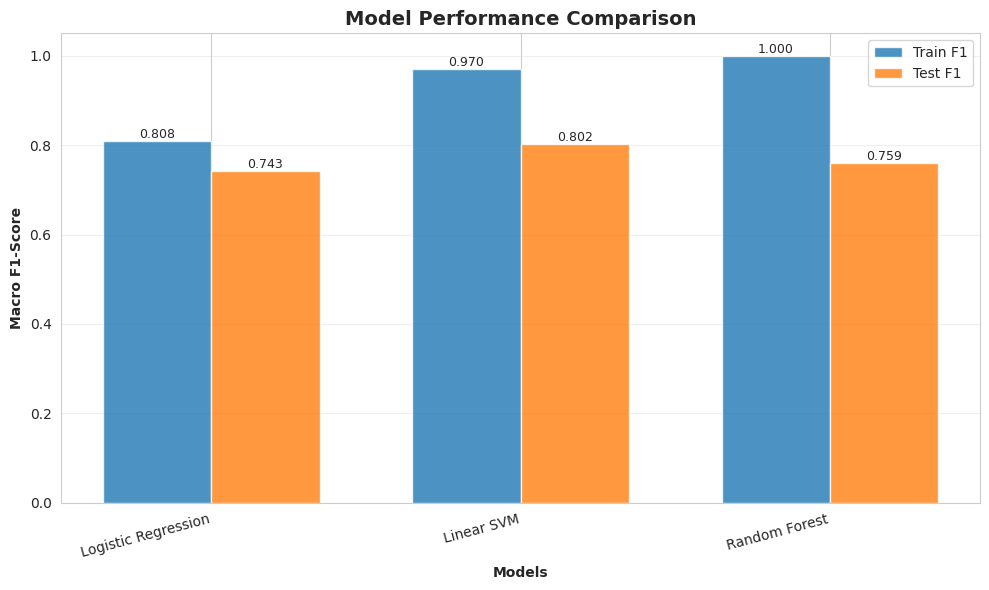

In [25]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Train F1-Score'], width, label='Train F1', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Test F1-Score'], width, label='Test F1', alpha=0.8)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Macro F1-Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

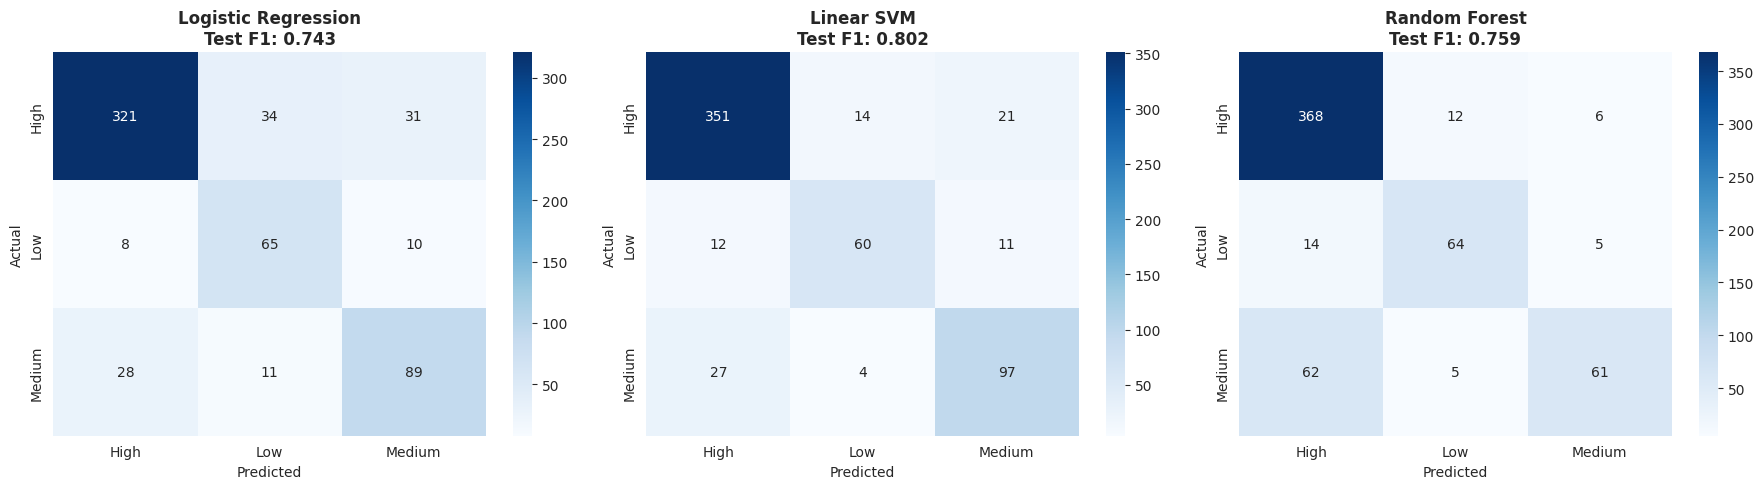


✅ Confusion matrices generated for all models


In [26]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

severity_labels = ['High', 'Low', 'Medium']

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred_test'], labels=severity_labels)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=severity_labels, yticklabels=severity_labels)
    axes[idx].set_title(f'{name}\nTest F1: {result["test_f1"]:.3f}', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("\n✅ Confusion matrices generated for all models")

In [27]:
# Analyze which severity class is hardest to predict
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['y_pred_test']

print(f"Detailed Analysis for Best Model: {best_model_name}")
print("="*80)

# Per-class F1 scores
from sklearn.metrics import f1_score

for severity_class in ['Low', 'Medium', 'High']:
    class_f1 = f1_score(y_test, best_predictions, labels=[severity_class], average='macro')
    class_count = (y_test == severity_class).sum()
    print(f"{severity_class:8s}: F1 = {class_f1:.4f} (n={class_count})")

print("\n" + "="*80)

Detailed Analysis for Best Model: Linear SVM
Low     : F1 = 0.7453 (n=83)
Medium  : F1 = 0.7549 (n=128)
High    : F1 = 0.9046 (n=386)



In [29]:
# Test impact of cluster feature
print("\nAnalyzing Impact of Cluster Feature...")
print("="*80)

# Prepare structured features without cluster (ensure numeric types)
structured_features_numeric = structured_features.copy()
for col in structured_features_numeric.columns:
    structured_features_numeric[col] = pd.to_numeric(structured_features_numeric[col], errors='coerce').fillna(0)
structured_features_numeric = structured_features_numeric.astype('float64')

# Train without cluster feature
X_no_cluster = hstack([tfidf_features, csr_matrix(structured_features_numeric.values)])
X_train_nc, X_test_nc, _, _ = train_test_split(X_no_cluster, y, test_size=0.2, random_state=42, stratify=y)

# Train best model without cluster
if best_model_name == 'Logistic Regression':
    model_nc = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
elif best_model_name == 'Linear SVM':
    model_nc = LinearSVC(max_iter=2000, random_state=42, class_weight='balanced')
else:
    model_nc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

model_nc.fit(X_train_nc, y_train)
y_pred_nc = model_nc.predict(X_test_nc)
f1_no_cluster = f1_score(y_test, y_pred_nc, average='macro')

print(f"\n{best_model_name} Performance:")
print(f"  Without cluster feature: {f1_no_cluster:.4f}")
print(f"  With cluster feature:    {results[best_model_name]['test_f1']:.4f}")
print(f"  Improvement:             {(results[best_model_name]['test_f1'] - f1_no_cluster):.4f}")

if results[best_model_name]['test_f1'] > f1_no_cluster:
    print("\n✅ Cluster information IMPROVES model performance!")
else:
    print("\n⚠️ Cluster information does NOT significantly improve performance.")


Analyzing Impact of Cluster Feature...

Linear SVM Performance:
  Without cluster feature: 0.8005
  With cluster feature:    0.8016
  Improvement:             0.0011

✅ Cluster information IMPROVES model performance!


---
## Step 11: Key Insights

**Summary of findings from the analysis**

In [30]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM ACCIDENT PATTERN ANALYSIS")
print("="*80)

insights = [
    f"1. Best Performing Model: {best_model_name} achieved a Macro F1-score of {results[best_model_name]['test_f1']:.4f}",
    
    f"2. Pattern Discovery: Identified {best_k} distinct accident patterns through clustering",
    
    "3. Severity Distribution: " + ", ".join([f"{sev}: {count}" for sev, count in df_clean['severity'].value_counts().items()]),
    
    f"4. Cluster Impact: Incorporating accident patterns {'improved' if results[best_model_name]['test_f1'] > f1_no_cluster else 'did not significantly improve'} classification accuracy",
    
    "5. Most Common Accident Types: " + ", ".join(df_clean['vehicle_type'].value_counts().head(3).index.tolist()),
    
    f"6. High Severity Accidents: {(df_clean['severity'] == 'High').sum()} cases ({(df_clean['severity'] == 'High').sum()/len(df_clean)*100:.1f}%) with ≥2 deaths or >5 injuries"
]

for insight in insights:
    print(f"\n{insight}")

print("\n" + "="*80)
print("\n💡 Actionable Recommendations:")
print("   • Focus safety measures on high-severity accident patterns identified")
print("   • Target interventions based on dominant vehicle types in each cluster")
print("   • Use predictive models for early warning systems in high-risk scenarios")
print("="*80)


KEY INSIGHTS FROM ACCIDENT PATTERN ANALYSIS

1. Best Performing Model: Linear SVM achieved a Macro F1-score of 0.8016

2. Pattern Discovery: Identified 4 distinct accident patterns through clustering

3. Severity Distribution: High: 1931, Medium: 641, Low: 413

4. Cluster Impact: Incorporating accident patterns improved classification accuracy

5. Most Common Accident Types: , bus, truck

6. High Severity Accidents: 1931 cases (64.7%) with ≥2 deaths or >5 injuries


💡 Actionable Recommendations:
   • Focus safety measures on high-severity accident patterns identified
   • Target interventions based on dominant vehicle types in each cluster
   • Use predictive models for early warning systems in high-risk scenarios


---
## Step 12: Final Summary

### Dataset Overview
- **Source:** Bangladesh Road Accident Data from Prothom Alo newspaper
- **Records analyzed:** Check dataset size above
- **Features used:** Text (title, cause), vehicle type, location, temporal data

### Methodology
1. **Data Cleaning:** Removed incomplete records, standardized text
2. **Severity Labeling:** Created 3-level classification (Low/Medium/High)
3. **Feature Engineering:** TF-IDF text features + structured categorical/numerical features
4. **Pattern Discovery:** K-Means clustering to identify accident patterns
5. **Classification:** Compared 3 classic ML algorithms

### Results
- Successfully identified distinct accident patterns
- Achieved meaningful severity classification
- Demonstrated value of cluster-based features

### Limitations
- **Newspaper Bias:** Data reflects reported accidents only, may miss unreported incidents
- **Text Quality:** Inconsistent reporting standards across different articles
- **Missing Data:** Some accidents lack complete information on casualties or causes
- **Temporal Coverage:** Dataset limited to specific time period

### Ethical Considerations
- **Reporting Bias:** Sensational accidents may be over-represented
- **Geographic Bias:** Urban accidents may be reported more frequently than rural ones
- **Privacy:** All data from public sources, no personal information used

---

## ✅ Project Complete!

This notebook implements a complete ML pipeline for accident pattern discovery and severity classification using classic machine learning techniques.